## Import Libraries

In [1]:
# Suppress warnings
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Core data processing libraries
import pandas as pd
import numpy as np
from datetime import datetime
import math
import time

# HTTP requests
import requests

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Machine Learning & Statistics
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import norm, t, ttest_1samp

# API clients
from pycoingecko import CoinGeckoAPI

# Portfolio Optimization (Hierarchical Risk Parity)
import riskfolio as rp

# Environment variables
from dotenv import load_dotenv
import os

# Backtesting
import bt

# Load environment variables
load_dotenv()

print("All libraries imported successfully!")

All libraries imported successfully!


## Initialize API Clients

In [2]:
# Initialize CoinGecko Pro API client
# Get API key from environment variable
GECKO_API_KEY = os.getenv('GECKO_API_KEY')

# Initialize CoinGecko client
cg = CoinGeckoAPI(api_key=GECKO_API_KEY) if GECKO_API_KEY else CoinGeckoAPI()

print(f"✓ CoinGecko API initialized: {'Pro' if GECKO_API_KEY else 'Free'}")

# Initialize Alpaca Trading Client
try:
    from alpaca.trading.client import TradingClient
    from alpaca.trading.requests import GetAssetsRequest
    from alpaca.trading.enums import AssetClass
    
    # Get Alpaca credentials from environment
    ALPACA_API_KEY = os.getenv('ALPACA_API_KEY')
    ALPACA_SECRET_KEY = os.getenv('SECRET_KEY')
    
    # Debug: Check if credentials are loaded (show first few chars only)
    print(f"\nDebug - Credentials loaded:")
    print(f"  - API Key: {ALPACA_API_KEY[:8] if ALPACA_API_KEY else 'None'}...")
    print(f"  - Secret Key: {ALPACA_SECRET_KEY[:8] if ALPACA_SECRET_KEY else 'None'}...")
    
    if ALPACA_API_KEY and ALPACA_SECRET_KEY:
        # Initialize Alpaca client (paper trading)
        alpaca_client = TradingClient(ALPACA_API_KEY, ALPACA_SECRET_KEY, paper=True)
        
        # Get account info
        try:
            account = alpaca_client.get_account()
            
            print(f"\n✓ Alpaca Trading Client initialized (Paper Trading)")
            print(f"  - Account Status: {account.status}")
            print(f"  - Buying Power: ${float(account.buying_power):,.2f}")
            print(f"  - Cash: ${float(account.cash):,.2f}")
            print(f"  - Portfolio Value: ${float(account.portfolio_value):,.2f}")
        except Exception as e:
            print(f"\n⚠️  Alpaca authentication failed: {str(e)}")
            print("\nPossible solutions:")
            print("1. Check if your .env file has no quotes around the keys:")
            print("   ALPACA_API_KEY=YOUR_KEY_HERE")
            print("   SECRET_KEY=YOUR_SECRET_HERE")
            print("2. Verify your keys are valid at https://alpaca.markets/")
            print("3. Make sure you have a paper trading account activated")
            print("4. Try regenerating your API keys on Alpaca dashboard")
            alpaca_client = None
        
    else:
        print("\n⚠️  Alpaca credentials not found in .env")
        print("   Add ALPACA_API_KEY and SECRET_KEY to your .env file")
        alpaca_client = None
        
except ImportError as e:
    print(f"\n⚠️  Alpaca library not installed: {e}")
    print("   Install with: pip install alpaca-py")
    alpaca_client = None

✓ CoinGecko API initialized: Pro

Debug - Credentials loaded:
  - API Key: PKVBQHJM...
  - Secret Key: FGHk3LKa...

✓ Alpaca Trading Client initialized (Paper Trading)
  - Account Status: AccountStatus.ACTIVE
  - Buying Power: $183,037.60
  - Cash: $91,518.80
  - Portfolio Value: $91,518.80

✓ Alpaca Trading Client initialized (Paper Trading)
  - Account Status: AccountStatus.ACTIVE
  - Buying Power: $183,037.60
  - Cash: $91,518.80
  - Portfolio Value: $91,518.80


### API Client Setup

**CoinGecko Pro API**: Provides comprehensive cryptocurrency market data including prices, market cap, volume, and historical data for portfolio optimization.

**Alpaca Trading API**: Executes crypto spot trades with commission-free trading. Using paper trading mode for safe strategy testing.

**Current Environment Variables** (from your `.env` file):
- ✓ `GECKO_API_KEY` - CoinGecko API key
- ✓ `ALPACA_API_KEY` - Alpaca API key for authentication
- ✓ `SECRET_KEY` - Alpaca secret key
- ✓ `BASE_URL` - Alpaca paper trading endpoint

**Why Alpaca instead of Drift?**
- ✅ Broader crypto coverage (supports major cryptocurrencies)
- ✅ Easy-to-use Python SDK (`alpaca-py`)
- ✅ Paper trading mode for risk-free testing
- ✅ Commission-free crypto trading
- ✅ Better for spot market strategies

## Investment Universe

In this section, we align the tradable cryptocurrency tickers from Alpaca with their corresponding coin IDs in CoinGecko. This alignment is crucial because:

- **Alpaca** uses trading symbols like `BTC/USD`, `ETH/USD`, `SOL/USD`
- **CoinGecko** identifies cryptocurrencies by coin IDs like `bitcoin`, `ethereum`, `solana`

By reconciling these formats, we ensure our HRP strategy only considers cryptocurrencies that are:
1. ✅ Tradable on Alpaca (can execute spot trades)
2. ✅ Have historical data available on CoinGecko (for portfolio optimization)
3. ✅ Have sufficient liquidity and trading volume

### Tradable Crypto Assets on Alpaca
First, let's fetch the available crypto assets from Alpaca and map them to CoinGecko IDs.

In [3]:
# Define Alpaca crypto trading pairs and their CoinGecko mappings
# Alpaca supports major cryptocurrencies for spot trading

alpaca_crypto_universe = {
    'BTC/USD': 'bitcoin',
    'ETH/USD': 'ethereum',
    'LTC/USD': 'litecoin',
    'BCH/USD': 'bitcoin-cash',
    'LINK/USD': 'chainlink',
    'AAVE/USD': 'aave',
    'UNI/USD': 'uniswap',
    'SUSHI/USD': 'sushi',
    'MATIC/USD': 'matic-network',
    'DOT/USD': 'polkadot',
    'AVAX/USD': 'avalanche-2',
    'TRX/USD': 'tron',
    'SHIB/USD': 'shiba-inu',
    'DOGE/USD': 'dogecoin',
    'XLM/USD': 'stellar',
    'SOL/USD': 'solana',
}

# Create a DataFrame for easy viewing
universe_df = pd.DataFrame([
    {'alpaca_symbol': symbol, 'coingecko_id': coin_id}
    for symbol, coin_id in alpaca_crypto_universe.items()
])

print(f"Investment Universe (Alpaca Crypto): {len(alpaca_crypto_universe)} tradable cryptocurrencies")
print(f"\n{universe_df.to_string(index=False)}")

# Store the list of CoinGecko IDs for data collection
coingecko_ids = list(alpaca_crypto_universe.values())
alpaca_symbols = list(alpaca_crypto_universe.keys())

print(f"\nCoinGecko IDs to fetch: {coingecko_ids}")
print(f"\nAlpaca symbols for trading: {alpaca_symbols}")
print(f"\nTotal assets for HRP portfolio: {len(coingecko_ids)}")

Investment Universe (Alpaca Crypto): 16 tradable cryptocurrencies

alpaca_symbol  coingecko_id
      BTC/USD       bitcoin
      ETH/USD      ethereum
      LTC/USD      litecoin
      BCH/USD  bitcoin-cash
     LINK/USD     chainlink
     AAVE/USD          aave
      UNI/USD       uniswap
    SUSHI/USD         sushi
    MATIC/USD matic-network
      DOT/USD      polkadot
     AVAX/USD   avalanche-2
      TRX/USD          tron
     SHIB/USD     shiba-inu
     DOGE/USD      dogecoin
      XLM/USD       stellar
      SOL/USD        solana

CoinGecko IDs to fetch: ['bitcoin', 'ethereum', 'litecoin', 'bitcoin-cash', 'chainlink', 'aave', 'uniswap', 'sushi', 'matic-network', 'polkadot', 'avalanche-2', 'tron', 'shiba-inu', 'dogecoin', 'stellar', 'solana']

Alpaca symbols for trading: ['BTC/USD', 'ETH/USD', 'LTC/USD', 'BCH/USD', 'LINK/USD', 'AAVE/USD', 'UNI/USD', 'SUSHI/USD', 'MATIC/USD', 'DOT/USD', 'AVAX/USD', 'TRX/USD', 'SHIB/USD', 'DOGE/USD', 'XLM/USD', 'SOL/USD']

Total assets for HRP port

### Verify CoinGecko Coverage
Let's verify that all our selected cryptocurrencies have data available on CoinGecko.

In [4]:
# Verify each coin exists on CoinGecko and get basic info
print("Verifying CoinGecko coverage...\n")

verified_coins = []
for coin_id in coingecko_ids:
    try:
        # Get coin data from CoinGecko
        coin_data = cg.get_coin_by_id(coin_id)
        
        verified_coins.append({
            'coingecko_id': coin_id,
            'name': coin_data['name'],
            'symbol': coin_data['symbol'].upper(),
            'market_cap_rank': coin_data.get('market_cap_rank', 'N/A'),
            'available': '✓'
        })
        
    except Exception as e:
        print(f"⚠️  Issue with {coin_id}: {str(e)}")
        verified_coins.append({
            'coingecko_id': coin_id,
            'name': 'N/A',
            'symbol': 'N/A',
            'market_cap_rank': 'N/A',
            'available': '✗'
        })

# Create verification DataFrame
verification_df = pd.DataFrame(verified_coins)
print(f"\n{verification_df.to_string(index=False)}")

# Summary
available_count = verification_df[verification_df['available'] == '✓'].shape[0]
print(f"\n✓ {available_count}/{len(coingecko_ids)} cryptocurrencies verified on CoinGecko")

Verifying CoinGecko coverage...


 coingecko_id                    name symbol  market_cap_rank available
      bitcoin                 Bitcoin    BTC              1.0         ✓
     ethereum                Ethereum    ETH              2.0         ✓
     litecoin                Litecoin    LTC             29.0         ✓
 bitcoin-cash            Bitcoin Cash    BCH             16.0         ✓
    chainlink               Chainlink   LINK             18.0         ✓
         aave                    Aave   AAVE             46.0         ✓
      uniswap                 Uniswap    UNI             43.0         ✓
        sushi                   Sushi  SUSHI            439.0         ✓
matic-network MATIC (migrated to POL)  MATIC              NaN         ✓
     polkadot                Polkadot    DOT             42.0         ✓
  avalanche-2               Avalanche   AVAX             30.0         ✓
         tron                    TRON    TRX              9.0         ✓
    shiba-inu               Sh

## Fetching Real-time & Historical Crypto Price Data

Now that we've identified our investment universe, we'll use the CoinGecko API to fetch both real-time and historical price data. This data is essential for:

1. **Portfolio Optimization**: Historical returns and covariance calculations for HRP
2. **Backtesting**: Testing our strategy on past data
3. **Risk Assessment**: Understanding volatility and correlation patterns

### Check Data Availability (Earliest Start Dates)

First, let's check when historical data becomes available for each cryptocurrency. This helps us:
- Identify assets with insufficient historical data
- Determine the optimal lookback period for our strategy
- Ensure all assets have overlapping data periods

In [5]:
# Check the earliest available data for each cryptocurrency
print("Checking earliest available data dates...\n")

data_availability = []

for coin_id in coingecko_ids:
    try:
        # Get market chart data from the earliest possible date
        # Using 'max' returns all available historical data
        market_data = cg.get_coin_market_chart_by_id(
            id=coin_id,
            vs_currency='usd',
            days='max'
        )
        
        # Extract the first timestamp
        if market_data['prices']:
            earliest_timestamp = market_data['prices'][0][0]
            earliest_date = datetime.fromtimestamp(earliest_timestamp / 1000)
            
            # Get current price
            current_price = market_data['prices'][-1][1]
            
            data_availability.append({
                'coingecko_id': coin_id,
                'symbol': verification_df[verification_df['coingecko_id'] == coin_id]['symbol'].values[0],
                'earliest_date': earliest_date.strftime('%Y-%m-%d'),
                'days_available': len(market_data['prices']),
                'current_price': f"${current_price:,.2f}"
            })
        else:
            data_availability.append({
                'coingecko_id': coin_id,
                'symbol': 'N/A',
                'earliest_date': 'No data',
                'days_available': 0,
                'current_price': 'N/A'
            })
            
    except Exception as e:
        print(f"⚠️  Error fetching data for {coin_id}: {str(e)}")
        data_availability.append({
            'coingecko_id': coin_id,
            'symbol': 'N/A',
            'earliest_date': 'Error',
            'days_available': 0,
            'current_price': 'N/A'
        })
    
    # Be respectful to API rate limits
    time.sleep(0.5)

# Create DataFrame
availability_df = pd.DataFrame(data_availability)
availability_df = availability_df.sort_values('earliest_date', ascending=True)

print(f"\n{availability_df.to_string(index=False)}")

# Analysis
print(f"\n{'='*70}")
print("Data Availability Analysis:")
print(f"{'='*70}")

# Find the most recent earliest date (this will be our constraint)
valid_dates = availability_df[availability_df['earliest_date'] != 'No data']['earliest_date']
if len(valid_dates) > 0:
    most_recent_start = max(valid_dates)
    print(f"Most recent earliest start date: {most_recent_start}")
    print(f"\nRecommendation: Use data from {most_recent_start} onwards")
    print(f"This ensures all {len(coingecko_ids)} cryptocurrencies have complete data")
    
    # Filter assets with insufficient data (optional)
    min_required_days = 365  # At least 1 year of data
    insufficient_data = availability_df[availability_df['days_available'] < min_required_days]
    
    if len(insufficient_data) > 0:
        print(f"\n⚠️  Assets with less than {min_required_days} days of data:")
        print(f"{insufficient_data[['symbol', 'coingecko_id', 'days_available']].to_string(index=False)}")
        print(f"\nConsider removing these from the portfolio for better backtesting accuracy")
else:
    print("No valid data found for any assets")

Checking earliest available data dates...


 coingecko_id symbol earliest_date  days_available current_price
      bitcoin    BTC    2013-04-28            4603    $92,253.41
     litecoin    LTC    2013-04-28            4603        $83.95
     dogecoin   DOGE    2013-12-15            4371         $0.15
      stellar    XLM    2014-08-06            4134         $0.25
     ethereum    ETH    2015-08-07            3773     $3,135.51
 bitcoin-cash    BCH    2017-08-02            3048       $575.76
    chainlink   LINK    2017-11-09            2949        $14.27
         tron    TRX    2017-11-09            2949         $0.29
matic-network  MATIC    2019-04-27            2368         $0.18
       solana    SOL    2020-04-11            2065       $139.62
    shiba-inu   SHIB    2020-08-01            1939         $0.00
     polkadot    DOT    2020-08-19            1935         $2.29
        sushi  SUSHI    2020-08-28            1926         $0.36
      uniswap    UNI    2020-09-17            

### Fetch Historical Daily Price Data

Now let's fetch the actual historical price data for our HRP strategy. We'll use daily closing prices for a specified lookback period.

In [6]:
# Fetch historical daily price data for all cryptocurrencies
# Using a 3-year lookback period to capture full market cycles

LOOKBACK_DAYS = 1095  # 3 years - captures full market cycle

print(f"Fetching {LOOKBACK_DAYS} days of historical price data...\n")

price_data = {}

for coin_id in coingecko_ids:
    try:
        # Fetch market chart data
        market_data = cg.get_coin_market_chart_by_id(
            id=coin_id,
            vs_currency='usd',
            days=LOOKBACK_DAYS
        )
        
        # Extract prices (timestamp, price pairs)
        prices = market_data['prices']
        
        # Convert to DataFrame
        df = pd.DataFrame(prices, columns=['timestamp', 'price'])
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df[['date', 'price']]
        df = df.set_index('date')
        
        # Get symbol for column name
        symbol = verification_df[verification_df['coingecko_id'] == coin_id]['symbol'].values[0]
        
        price_data[symbol] = df['price']
        
        print(f"✓ {symbol:8s} - {len(df)} data points, Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
        
    except Exception as e:
        print(f"✗ {coin_id} - Error: {str(e)}")
    
    # Respect API rate limits
    time.sleep(0.5)

# Combine all price data into a single DataFrame
prices_df = pd.DataFrame(price_data)

print(f"\n{'='*70}")
print(f"Historical Price Data Summary:")
print(f"{'='*70}")
print(f"Date range: {prices_df.index.min()} to {prices_df.index.max()}")
print(f"Total data points: {len(prices_df)}")
print(f"Cryptocurrencies: {len(prices_df.columns)}")
print(f"\nDataFrame shape: {prices_df.shape}")
print(f"\nMissing values per asset:")
print(prices_df.isnull().sum())

# Display first few rows
print(f"\nFirst 5 rows:")
print(prices_df.head())

Fetching 1095 days of historical price data...

✓ BTC      - 1096 data points, Price range: $16422.56 - $124773.51
✓ BTC      - 1096 data points, Price range: $16422.56 - $124773.51
✓ ETH      - 1096 data points, Price range: $1165.97 - $4829.23
✓ ETH      - 1096 data points, Price range: $1165.97 - $4829.23
✓ LTC      - 1096 data points, Price range: $56.02 - $136.86
✓ LTC      - 1096 data points, Price range: $56.02 - $136.86
✓ BCH      - 1096 data points, Price range: $96.46 - $695.34
✓ BCH      - 1096 data points, Price range: $96.46 - $695.34
✓ LINK     - 1096 data points, Price range: $5.12 - $29.43
✓ LINK     - 1096 data points, Price range: $5.12 - $29.43
✓ AAVE     - 1096 data points, Price range: $50.09 - $383.49
✓ AAVE     - 1096 data points, Price range: $50.09 - $383.49
✓ UNI      - 1096 data points, Price range: $3.89 - $18.71
✓ UNI      - 1096 data points, Price range: $3.89 - $18.71
✓ SUSHI    - 1096 data points, Price range: $0.34 - $2.64
✓ SUSHI    - 1096 data points,

### Data Cleaning and Validation

Let's clean the data by handling missing values and ensuring data quality.

In [7]:
# Clean and validate the price data
print("Data Quality Check:")
print(f"{'='*70}\n")

# Check for missing data
print("Missing data summary:")
missing_summary = pd.DataFrame({
    'Asset': prices_df.columns,
    'Missing_Count': prices_df.isnull().sum().values,
    'Missing_Percentage': (prices_df.isnull().sum() / len(prices_df) * 100).values,
    'Has_Data': (prices_df.notnull().sum() > 0).values
})
print(missing_summary.to_string(index=False))

# Remove assets with no data
assets_with_data = prices_df.columns[prices_df.notnull().any()].tolist()
assets_without_data = prices_df.columns[~prices_df.notnull().any()].tolist()

print(f"\n{'='*70}")
print(f"Assets with data: {len(assets_with_data)}")
print(f"Assets without data: {len(assets_without_data)}")

if assets_without_data:
    print(f"\n⚠️  Removing assets with no data: {assets_without_data}")
    prices_df_clean = prices_df[assets_with_data].copy()
else:
    prices_df_clean = prices_df.copy()

# Forward fill missing values (use previous day's price)
prices_df_clean = prices_df_clean.ffill()

# Backward fill any remaining missing values at the start
prices_df_clean = prices_df_clean.bfill()

# Drop any rows that still have missing values
initial_rows = len(prices_df_clean)
prices_df_clean = prices_df_clean.dropna()
rows_dropped = initial_rows - len(prices_df_clean)

print(f"\n{'='*70}")
print("Cleaned Data Summary:")
print(f"{'='*70}")
print(f"Rows dropped due to missing values: {rows_dropped}")
print(f"Final shape: {prices_df_clean.shape}")
print(f"Date range: {prices_df_clean.index.min()} to {prices_df_clean.index.max()}")
print(f"Assets in cleaned dataset: {list(prices_df_clean.columns)}")

# Update the main dataframe
prices_df = prices_df_clean

print(f"\n✓ Data cleaning complete!")
print(f"Final dataset: {len(prices_df)} days × {len(prices_df.columns)} assets")

Data Quality Check:

Missing data summary:
Asset  Missing_Count  Missing_Percentage  Has_Data
  BTC             12            1.083032      True
  ETH             12            1.083032      True
  LTC             12            1.083032      True
  BCH             12            1.083032      True
 LINK             12            1.083032      True
 AAVE             12            1.083032      True
  UNI             12            1.083032      True
SUSHI             12            1.083032      True
MATIC             59            5.324910      True
  DOT             12            1.083032      True
 AVAX             12            1.083032      True
  TRX             12            1.083032      True
 SHIB             12            1.083032      True
 DOGE             12            1.083032      True
  XLM             12            1.083032      True
  SOL             12            1.083032      True

Assets with data: 16
Assets without data: 0

Cleaned Data Summary:
Rows dropped due to mi

### Visualize Price Trends

Let's visualize the normalized price trends to understand the relative performance of each cryptocurrency.

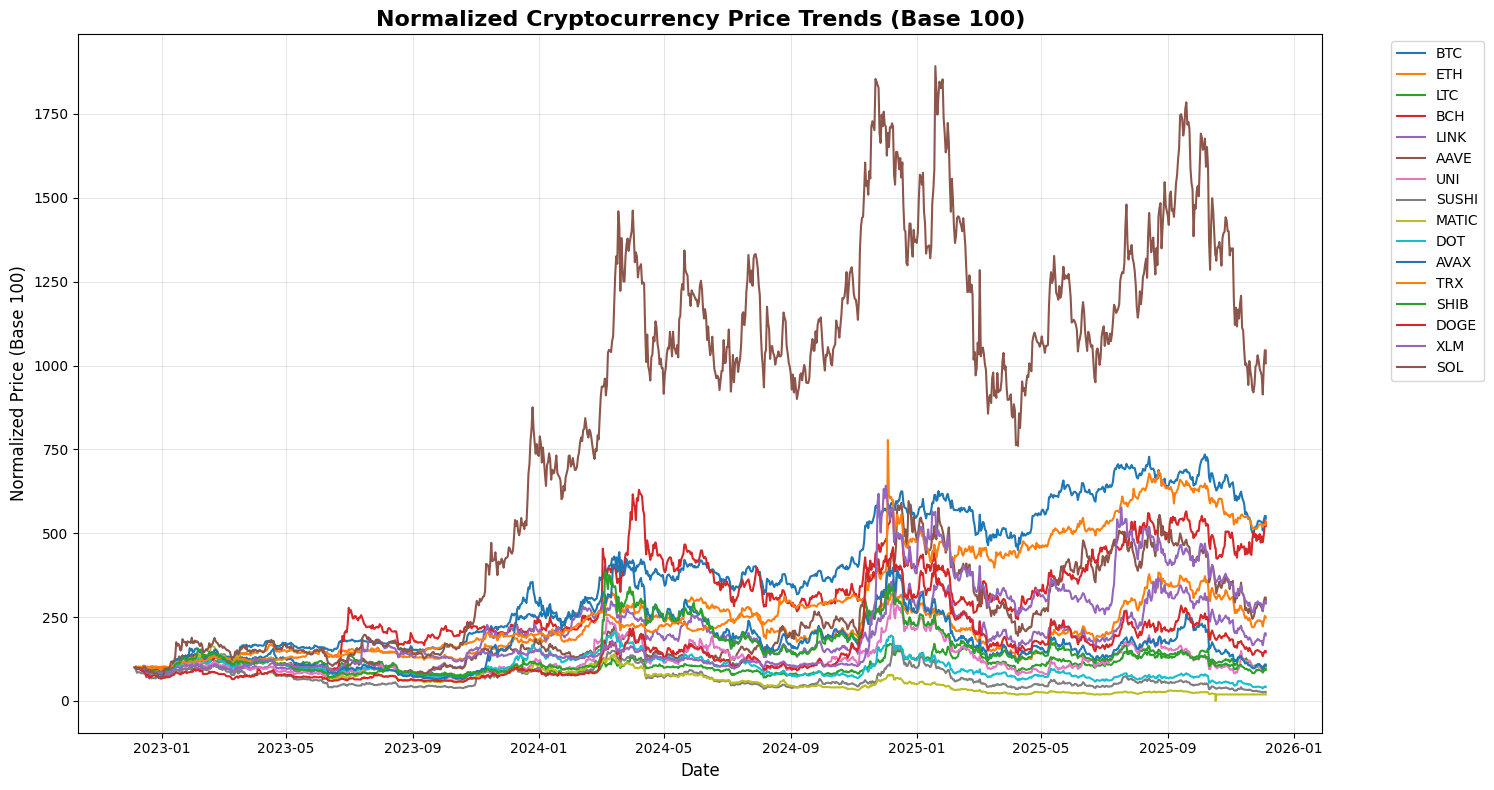


Performance Summary (1095 days):

Asset  Return (%)  Final Value
  SOL  906.443741  1006.443741
  BTC  443.518242   543.518242
  TRX  433.854347   533.854347
  BCH  421.239645   521.239645
 AAVE  196.445866   296.445866
  XLM  190.428879   290.428879
  ETH  148.899110   248.899110
 LINK   95.903756   195.903756
 DOGE   45.166575   145.166575
 AVAX    6.180552   106.180552
  LTC    4.602897   104.602897
  UNI   -3.686085    96.313915
 SHIB   -7.520736    92.479264
  DOT  -58.351766    41.648234
SUSHI  -74.270029    25.729971
MATIC  -80.534027    19.465973

Best Performer: SOL (+906.44%)
Worst Performer: MATIC (-80.53%)


In [8]:
# Visualize normalized price trends
# Normalize to 100 at the start for easy comparison

normalized_prices = (prices_df / prices_df.iloc[0]) * 100

plt.figure(figsize=(15, 8))
for column in normalized_prices.columns:
    plt.plot(normalized_prices.index, normalized_prices[column], label=column, linewidth=1.5)

plt.title('Normalized Cryptocurrency Price Trends (Base 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price (Base 100)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Performance summary
returns = normalized_prices.iloc[-1] - 100
print(f"\n{'='*70}")
print(f"Performance Summary ({LOOKBACK_DAYS} days):")
print(f"{'='*70}")

performance_summary = pd.DataFrame({
    'Asset': returns.index,
    'Return (%)': returns.values,
    'Final Value': normalized_prices.iloc[-1].values
}).sort_values('Return (%)', ascending=False)

print(f"\n{performance_summary.to_string(index=False)}")

print(f"\nBest Performer: {performance_summary.iloc[0]['Asset']} (+{performance_summary.iloc[0]['Return (%)']:.2f}%)")
print(f"Worst Performer: {performance_summary.iloc[-1]['Asset']} ({performance_summary.iloc[-1]['Return (%)']:.2f}%)")

## Additional Market Data Collection

To enhance our HRP strategy with comprehensive market analysis, we'll collect additional data including volume, market cap, and market sentiment indicators.

### Fetch Volume and Market Cap Data

Trading volume and market capitalization are critical for understanding liquidity and position sizing.

In [9]:
# Fetch volume and market cap data for all cryptocurrencies
print("Fetching volume and market cap data...\n")

volume_data = {}
market_cap_data = {}

# Get list of assets that have price data
valid_symbols = prices_df.columns.tolist()
valid_coin_ids = [coin_id for symbol, coin_id in zip(verification_df['symbol'], verification_df['coingecko_id']) 
                  if symbol in valid_symbols]

for coin_id in valid_coin_ids:
    try:
        # Fetch market chart data
        market_data = cg.get_coin_market_chart_by_id(
            id=coin_id,
            vs_currency='usd',
            days=LOOKBACK_DAYS
        )
        
        # Extract volume data
        volumes = market_data['total_volumes']
        df_vol = pd.DataFrame(volumes, columns=['timestamp', 'volume'])
        df_vol['date'] = pd.to_datetime(df_vol['timestamp'], unit='ms')
        df_vol = df_vol.set_index('date')
        
        # Extract market cap data
        market_caps = market_data['market_caps']
        df_mcap = pd.DataFrame(market_caps, columns=['timestamp', 'market_cap'])
        df_mcap['date'] = pd.to_datetime(df_mcap['timestamp'], unit='ms')
        df_mcap = df_mcap.set_index('date')
        
        # Get symbol
        symbol = verification_df[verification_df['coingecko_id'] == coin_id]['symbol'].values[0]
        
        volume_data[symbol] = df_vol['volume']
        market_cap_data[symbol] = df_mcap['market_cap']
        
        print(f"✓ {symbol:8s} - Volume & Market Cap collected")
        
    except Exception as e:
        print(f"✗ {coin_id} - Error: {str(e)}")
    
    time.sleep(0.5)

# Create DataFrames
volumes_df = pd.DataFrame(volume_data)
market_caps_df = pd.DataFrame(market_cap_data)

# Clean data
volumes_df = volumes_df.ffill().bfill()
market_caps_df = market_caps_df.ffill().bfill()

print(f"\n{'='*70}")
print("Volume & Market Cap Data Summary:")
print(f"{'='*70}")
print(f"Volume data shape: {volumes_df.shape}")
print(f"Market cap data shape: {market_caps_df.shape}")
print(f"\nAverage daily volume (USD):")
print(volumes_df.mean().sort_values(ascending=False).apply(lambda x: f"${x:,.0f}"))

Fetching volume and market cap data...

✓ BTC      - Volume & Market Cap collected
✓ BTC      - Volume & Market Cap collected
✓ ETH      - Volume & Market Cap collected
✓ ETH      - Volume & Market Cap collected
✓ LTC      - Volume & Market Cap collected
✓ LTC      - Volume & Market Cap collected
✓ BCH      - Volume & Market Cap collected
✓ BCH      - Volume & Market Cap collected
✓ LINK     - Volume & Market Cap collected
✓ LINK     - Volume & Market Cap collected
✓ AAVE     - Volume & Market Cap collected
✓ AAVE     - Volume & Market Cap collected
✓ UNI      - Volume & Market Cap collected
✓ UNI      - Volume & Market Cap collected
✓ SUSHI    - Volume & Market Cap collected
✓ SUSHI    - Volume & Market Cap collected
✓ MATIC    - Volume & Market Cap collected
✓ MATIC    - Volume & Market Cap collected
✓ DOT      - Volume & Market Cap collected
✓ DOT      - Volume & Market Cap collected
✓ AVAX     - Volume & Market Cap collected
✓ AVAX     - Volume & Market Cap collected
✓ TRX      - V

### Calculate Risk Metrics

Essential risk metrics for portfolio optimization including returns, volatility, and maximum drawdown.

Calculating risk metrics...

Risk Metrics Summary:

Asset  Ann_Return (%)  Ann_Volatility (%)  Sharpe_Ratio  Max_Drawdown (%)
  BTC       66.451665           46.249637      1.436804        -32.130926
  SOL      115.360573           89.514298      1.288739        -59.824073
  TRX       73.271760           67.108701      1.091837        -48.955591
  BCH       88.186282           85.125954      1.035951        -61.324970
 AAVE       75.831451           90.025477      0.842333        -67.416516
  XLM       72.158604           90.894704      0.793870        -60.544089
  ETH       49.666544           62.955487      0.788915        -63.853992
 LINK       57.797929           85.019380      0.679821        -62.988402
 DOGE       49.881966           87.337114      0.571143        -70.894450
 AVAX       41.660017           89.359344      0.466208        -78.806641
  UNI       45.618965           99.372909      0.459068        -74.544477
 SHIB       35.040713           89.537231      0.391354     

/Users/olaoluwatunmise/rust_lang_book/risk-parity-ml/risk-parity/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/olaoluwatunmise/rust_lang_book/risk-parity-ml/risk-parity/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


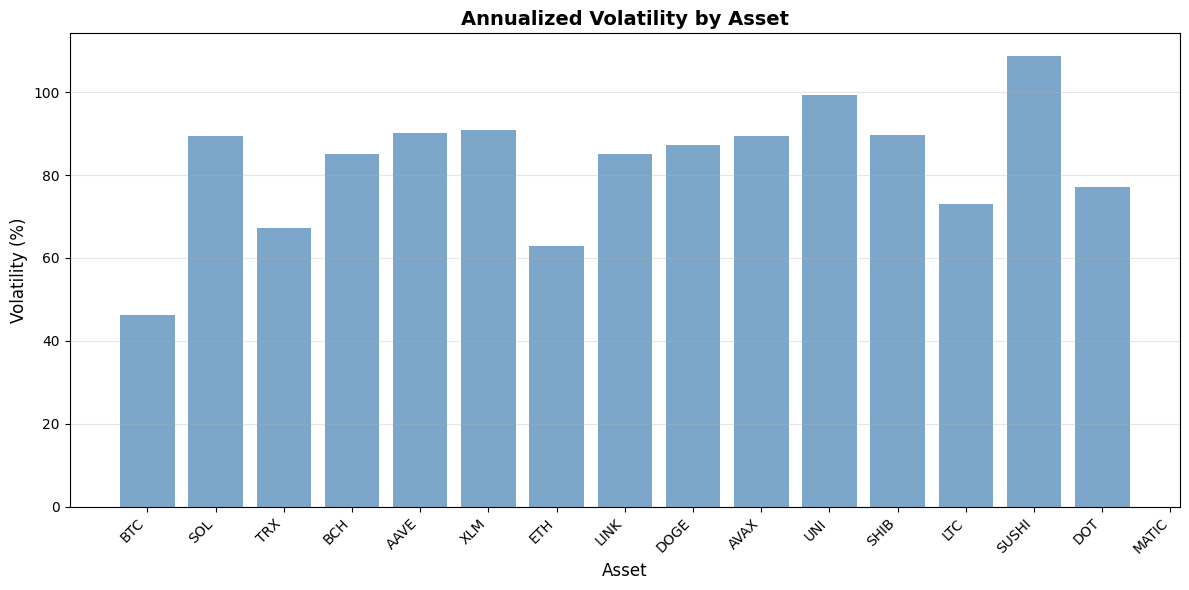


✓ Risk metrics calculated for 16 assets


In [10]:
# Calculate comprehensive risk metrics
print("Calculating risk metrics...\n")

# Daily returns
returns_df = prices_df.pct_change().dropna()

# Annualized metrics
annualized_return = returns_df.mean() * 365
annualized_volatility = returns_df.std() * np.sqrt(365)

# Sharpe ratio (assuming 0% risk-free rate for crypto)
sharpe_ratio = annualized_return / annualized_volatility

# Rolling volatility (30-day window)
rolling_vol_30d = returns_df.rolling(window=30).std() * np.sqrt(365)

# Maximum drawdown function
def calculate_max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.expanding().max()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()

max_drawdowns = returns_df.apply(calculate_max_drawdown)

# Compile risk metrics
risk_metrics = pd.DataFrame({
    'Asset': returns_df.columns,
    'Ann_Return (%)': (annualized_return * 100).values,
    'Ann_Volatility (%)': (annualized_volatility * 100).values,
    'Sharpe_Ratio': sharpe_ratio.values,
    'Max_Drawdown (%)': (max_drawdowns * 100).values
}).sort_values('Sharpe_Ratio', ascending=False)

print(f"{'='*70}")
print("Risk Metrics Summary:")
print(f"{'='*70}\n")
print(risk_metrics.to_string(index=False))

# Visualize annualized volatility
plt.figure(figsize=(12, 6))
plt.bar(risk_metrics['Asset'], risk_metrics['Ann_Volatility (%)'], color='steelblue', alpha=0.7)
plt.title('Annualized Volatility by Asset', fontsize=14, fontweight='bold')
plt.xlabel('Asset', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Risk metrics calculated for {len(risk_metrics)} assets")

### Correlation & Covariance Analysis

Calculate correlation and covariance matrices - essential for HRP clustering and risk parity calculations.

Calculating correlation and covariance matrices...

Correlation matrix shape: (16, 16)
Covariance matrix shape: (16, 16)



/Users/olaoluwatunmise/rust_lang_book/risk-parity-ml/risk-parity/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


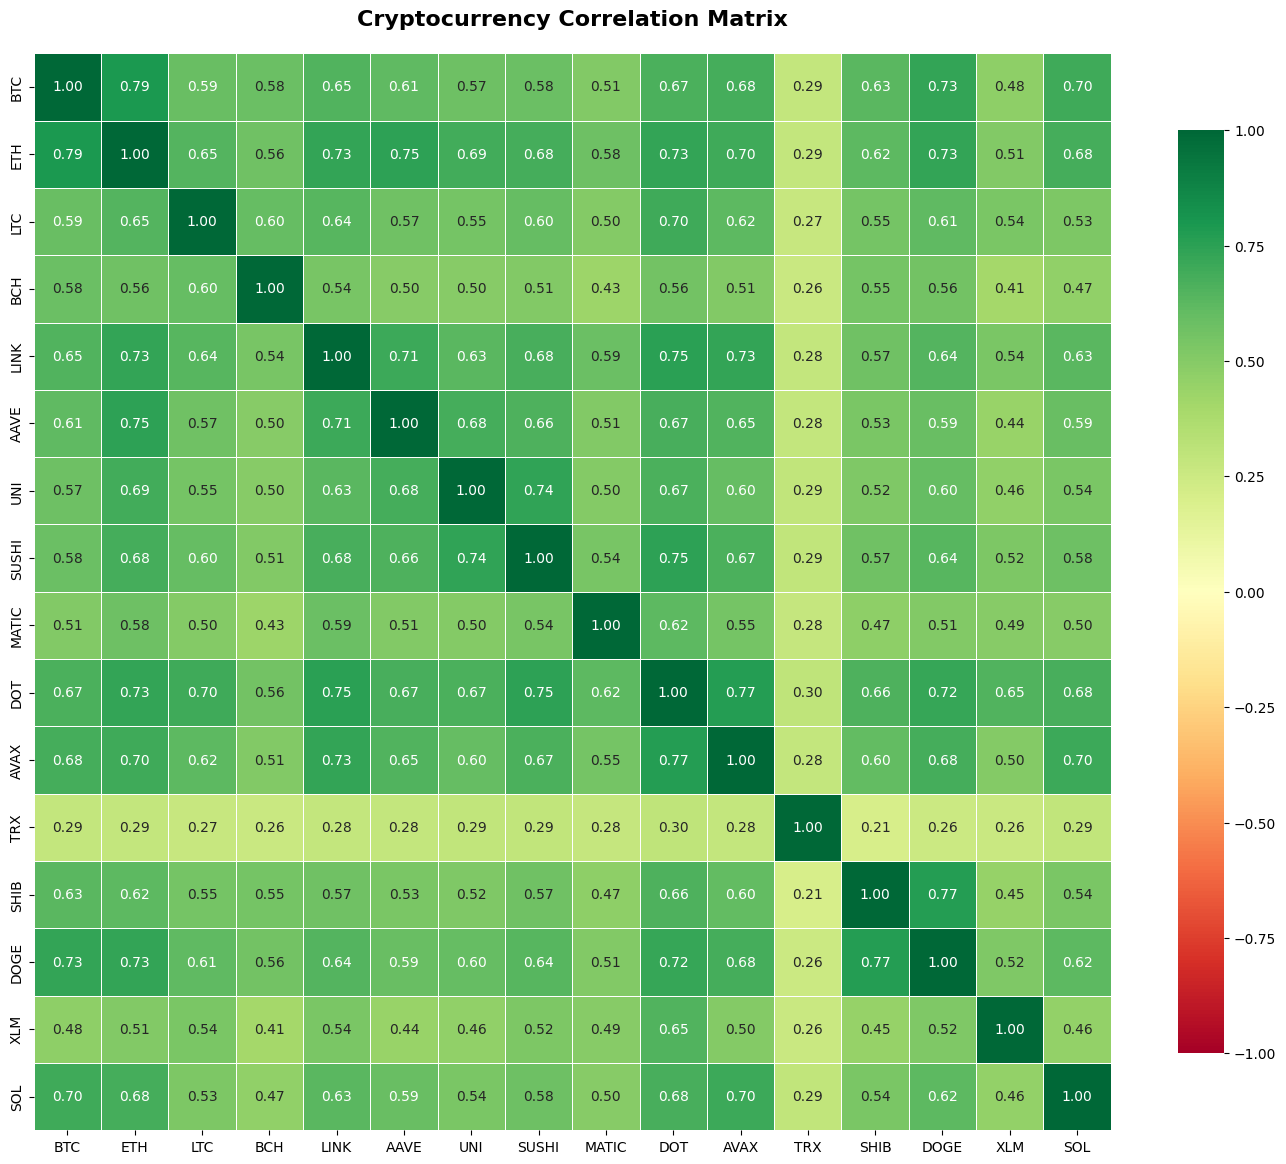

Correlation Statistics:
Average correlation: 0.560
Maximum correlation: 0.792
Minimum correlation: 0.206
Median correlation: 0.576

Top 5 most correlated pairs:
  BTC - ETH: 0.792
  DOT - AVAX: 0.773
  SHIB - DOGE: 0.770
  LINK - DOT: 0.751
  SUSHI - DOT: 0.749

Top 5 least correlated pairs:
  LTC - TRX: 0.269
  BCH - TRX: 0.261
  TRX - XLM: 0.260
  TRX - DOGE: 0.256
  TRX - SHIB: 0.206

✓ Correlation and covariance analysis complete


In [11]:
# Calculate correlation and covariance matrices
print("Calculating correlation and covariance matrices...\n")

# Correlation matrix
correlation_matrix = returns_df.corr()

# Covariance matrix (annualized)
covariance_matrix = returns_df.cov() * 252  # Annualized (using 252 trading days)

print(f"Correlation matrix shape: {correlation_matrix.shape}")
print(f"Covariance matrix shape: {covariance_matrix.shape}\n")

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Cryptocurrency Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation statistics
print(f"{'='*70}")
print("Correlation Statistics:")
print(f"{'='*70}")

# Get upper triangle of correlation matrix (exclude diagonal)
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

print(f"Average correlation: {upper_triangle.stack().mean():.3f}")
print(f"Maximum correlation: {upper_triangle.stack().max():.3f}")
print(f"Minimum correlation: {upper_triangle.stack().min():.3f}")
print(f"Median correlation: {upper_triangle.stack().median():.3f}")

# Find most and least correlated pairs
correlations = upper_triangle.stack().sort_values(ascending=False)
print(f"\nTop 5 most correlated pairs:")
for (asset1, asset2), corr in correlations.head(5).items():
    print(f"  {asset1} - {asset2}: {corr:.3f}")

print(f"\nTop 5 least correlated pairs:")
for (asset1, asset2), corr in correlations.tail(5).items():
    print(f"  {asset1} - {asset2}: {corr:.3f}")

print(f"\n✓ Correlation and covariance analysis complete")

### Market Sentiment Data

Fetch Fear & Greed Index for market sentiment analysis.

Fetching Fear & Greed Index...

✓ Fear & Greed Index collected: 1095 data points
  Date range: 2022-12-05 to 2025-12-04
  Current value: 26 (Fear)
✓ Fear & Greed Index collected: 1095 data points
  Date range: 2022-12-05 to 2025-12-04
  Current value: 26 (Fear)


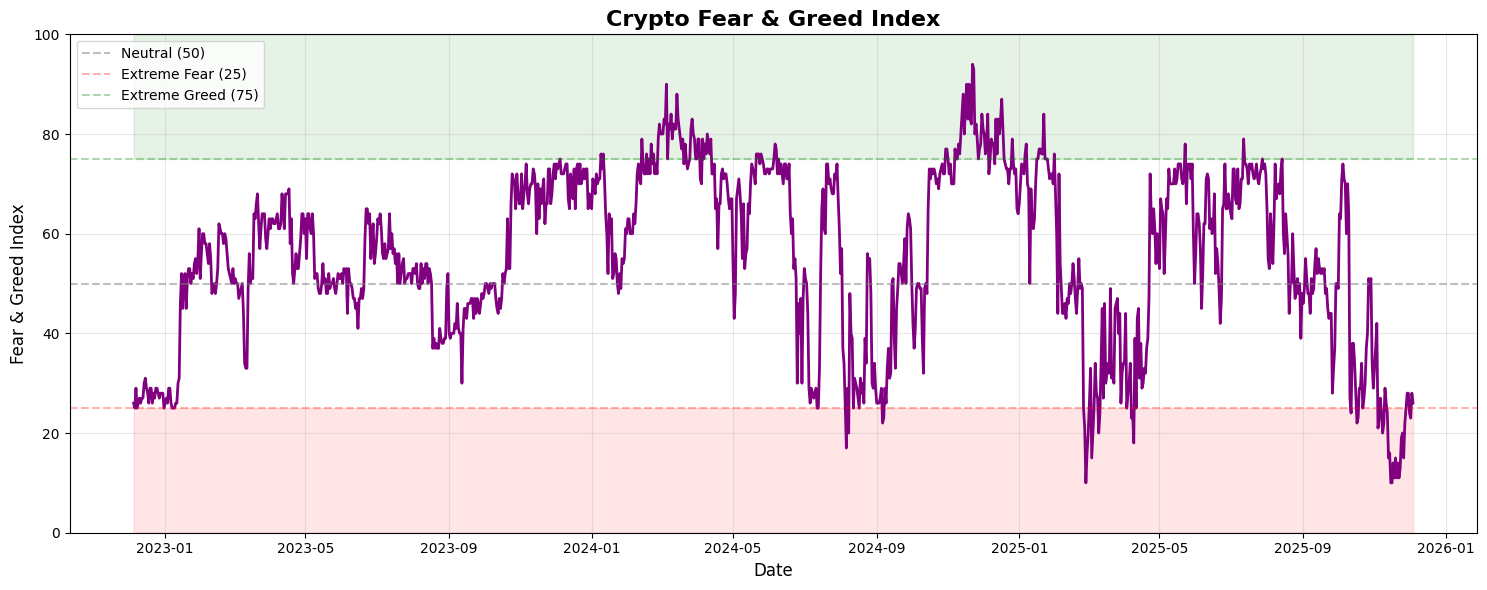


Fear & Greed Statistics:
Mean: 55.72
Median: 56.00
Min: 10.00
Max: 94.00

Sentiment distribution:
  Greed: 485 days (44.3%)
  Neutral: 237 days (21.6%)
  Fear: 220 days (20.1%)
  Extreme Greed: 96 days (8.8%)
  Extreme Fear: 57 days (5.2%)


In [12]:
# Fetch Crypto Fear & Greed Index
print("Fetching Fear & Greed Index...\n")

try:
    # Fetch last 1095 days of Fear & Greed Index (3 years)
    fng_response = requests.get('https://api.alternative.me/fng/?limit=1095&format=json')
    fng_data = fng_response.json()
    
    # Parse data
    fng_df = pd.DataFrame(fng_data['data'])
    fng_df['timestamp'] = pd.to_datetime(fng_df['timestamp'].astype(int), unit='s')
    fng_df = fng_df.set_index('timestamp')
    fng_df['value'] = fng_df['value'].astype(float)
    fng_df = fng_df.sort_index()
    
    print(f"✓ Fear & Greed Index collected: {len(fng_df)} data points")
    print(f"  Date range: {fng_df.index.min().date()} to {fng_df.index.max().date()}")
    print(f"  Current value: {fng_df['value'].iloc[-1]:.0f} ({fng_df['value_classification'].iloc[-1]})")
    
    # Visualize Fear & Greed over time
    plt.figure(figsize=(15, 6))
    plt.plot(fng_df.index, fng_df['value'], color='purple', linewidth=2)
    plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Neutral (50)')
    plt.axhline(y=25, color='red', linestyle='--', alpha=0.3, label='Extreme Fear (25)')
    plt.axhline(y=75, color='green', linestyle='--', alpha=0.3, label='Extreme Greed (75)')
    
    plt.fill_between(fng_df.index, 0, 25, alpha=0.1, color='red')
    plt.fill_between(fng_df.index, 75, 100, alpha=0.1, color='green')
    
    plt.title('Crypto Fear & Greed Index', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Fear & Greed Index', fontsize=12)
    plt.ylim(0, 100)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\n{'='*70}")
    print("Fear & Greed Statistics:")
    print(f"{'='*70}")
    print(f"Mean: {fng_df['value'].mean():.2f}")
    print(f"Median: {fng_df['value'].median():.2f}")
    print(f"Min: {fng_df['value'].min():.2f}")
    print(f"Max: {fng_df['value'].max():.2f}")
    
    # Distribution of sentiment
    sentiment_counts = fng_df['value_classification'].value_counts()
    print(f"\nSentiment distribution:")
    for sentiment, count in sentiment_counts.items():
        print(f"  {sentiment}: {count} days ({count/len(fng_df)*100:.1f}%)")
    
except Exception as e:
    print(f"✗ Error fetching Fear & Greed Index: {str(e)}")
    fng_df = None

## Save Data with Joblib

Save all collected data using joblib for efficient storage and fast loading in future notebooks.

In [13]:
import joblib
import os
from datetime import datetime

# Create data directory if it doesn't exist
data_dir = '../data'
os.makedirs(data_dir, exist_ok=True)

# Prepare data dictionary with all collected datasets
data_package = {
    'prices_df': prices_df,
    'returns_df': returns_df,
    'volumes_df': volumes_df,
    'market_caps_df': market_caps_df,
    'correlation_matrix': correlation_matrix,
    'covariance_matrix': covariance_matrix,
    'risk_metrics': risk_metrics,
    'fng_df': fng_df,
    'metadata': {
        'collection_date': datetime.now().isoformat(),
        'lookback_days': LOOKBACK_DAYS,
        'num_assets': len(prices_df.columns),
        'date_range': {
            'start': str(prices_df.index.min()),
            'end': str(prices_df.index.max())
        },
        'assets': list(prices_df.columns)
    }
}

# Save with joblib (compressed)
joblib_file = os.path.join(data_dir, 'crypto_data.joblib')
joblib.dump(data_package, joblib_file, compress=3)

print("✓ Data saved successfully with joblib")
print(f"\nFile: {joblib_file}")
print(f"Size: {os.path.getsize(joblib_file) / 1024:.2f} KB")

# Display what was saved
print(f"\n{'='*70}")
print("Saved Data Summary:")
print(f"{'='*70}")
for key, value in data_package.items():
    if key != 'metadata':
        if hasattr(value, 'shape'):
            print(f"  {key:25s} - Shape: {value.shape}")
        else:
            print(f"  {key:25s} - Type: {type(value).__name__}")

print(f"\nMetadata:")
for key, value in data_package['metadata'].items():
    if key != 'assets':
        print(f"  {key:25s} - {value}")

print(f"\n{'='*70}")
print("To load this data in another notebook, use:")
print(f"{'='*70}")
print("import joblib")
print("data = joblib.load('../data/crypto_data.joblib')")
print("prices_df = data['prices_df']")
print("returns_df = data['returns_df']")
print("# ... etc")

✓ Data saved successfully with joblib

File: ../data/crypto_data.joblib
Size: 557.28 KB

Saved Data Summary:
  prices_df                 - Shape: (1108, 16)
  returns_df                - Shape: (1107, 16)
  volumes_df                - Shape: (1108, 16)
  market_caps_df            - Shape: (1108, 16)
  correlation_matrix        - Shape: (16, 16)
  covariance_matrix         - Shape: (16, 16)
  risk_metrics              - Shape: (16, 5)
  fng_df                    - Shape: (1095, 3)

Metadata:
  collection_date           - 2025-12-04T22:38:40.074161
  lookback_days             - 1095
  num_assets                - 16
  date_range                - {'start': '2022-12-06 00:00:00', 'end': '2025-12-04 21:38:21'}

To load this data in another notebook, use:
import joblib
data = joblib.load('../data/crypto_data.joblib')
prices_df = data['prices_df']
returns_df = data['returns_df']
# ... etc
